In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_930958/3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import argparse
import os
import time
import datetime
import sys 
sys.path.append("../") 

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as io
import pandas as pd

from utils.dataset import *
from utils.networks import *
from utils.functions import *

plt.rcParams.update({'font.size':18})

In [3]:
# 初始化路径
data_path = './data'
figure_path = './figure'
log_path = './log'
model_path = './model'

for p in [figure_path, log_path, model_path]:
    if not os.path.exists(p):
        os.makedirs(p)

In [4]:
# 导入外部数据
data = io.loadmat(os.path.join(data_path, 'NS_Switch/udata3.mat'))
siwtch_nu = 0.03
U = data["U"]
V = data["V"]
P = data["P"]

# 生成网格点形如[Ny, Nx, Nt] 适用
Nx = 65
Ny = 65
Nt = 129
x = np.linspace(0, 1, Nx)
y = np.linspace(0, 1, Ny)
t = np.linspace(0, 1, Nt)

xx, yy = np.meshgrid(x, y)

xxx = np.repeat(xx[:, :, None], Nt, axis=2)
yyy = np.repeat(yy[:, :, None], Nt, axis=2)

tt = np.repeat(t[None, :], Nx, axis=0)
ttt = np.repeat(tt[None, :, :], Ny, axis=0)

In [5]:
# U_D, U_M = (U.max() - U.min()), U.mean()
# V_D, V_M = (V.max() - V.min()), V.mean()
# P_D, P_M = (P.max() - P.min()), P.mean()

## 超参数设置

In [6]:
domain = (0, 1, 0, 1, 0, 1)  # x, y, t
n_res = 5000
n_obs = 5000
n_iters = 50000
backbone_layers = [3] + [20]*6 + [3]
nn_param_layers = [1] + [20]*2 + [1]
backbone_lr = 1e-4
nn_param_lr = 1e-3
backbone_gamma = 0.70
nn_param_gamma = 0.70
lam_u_res = 1.
lam_v_res = 1.
lam_u_obs = 10.
lam_v_obs = 10.
lam_p_obs = 0.
device = torch.device("cuda")

init_ada_scale = 3e-2 ** 0.5

## 数据集生成

In [7]:
class Dataset_NavierStokes2d(Dataset2dT):
    """NavierStokes2d定制数据集"""

    def update_all_data(self):
        if "X_obs" not in self.datad.keys():
            # 只获取一次观测点，之后不更新
            self.external_data(n_obs)  # 引用全局变量
        
        self.interior_random(n_res)  # 引用全局变量
        self.func_res()

    def external_data(self, n_obs):
        # 读取外部数据
        data = io.loadmat(os.path.join(data_path, 'NS_Switch/udata3.mat'))
        U = data["U"]
        V = data["V"]
        P = data["P"]

        # 生成网格点形如[Ny, Nx, Nt]
        Nx = 65
        Ny = 65
        Nt = 129
        x = np.linspace(self.xmin, self.xmax, Nx)
        y = np.linspace(self.ymin, self.ymax, Ny)
        t = np.linspace(self.tmin, self.tmax, Nt)

        xx, yy = np.meshgrid(x, y)

        xxx = np.repeat(xx[:, :, None], Nt, axis=2)
        yyy = np.repeat(yy[:, :, None], Nt, axis=2)

        tt = np.repeat(t[None, :], Nx, axis=0)
        ttt = np.repeat(tt[None, :, :], Ny, axis=0)
        
        U = U.flatten()
        V = V.flatten()
        P = P.flatten()
        xxx = xxx.flatten()
        yyy = yyy.flatten()
        ttt = ttt.flatten()
        idx_obs = np.random.permutation(U.size)[:n_obs]
        
        X_obs = np.stack([xxx, yyy, ttt], axis=1)[idx_obs]
        u_obs = U.reshape(-1, 1)[idx_obs]
        v_obs = V.reshape(-1, 1)[idx_obs]
        p_obs = P.reshape(-1, 1)[idx_obs]

        # 将数据存入data字典
        self.datad["X_obs"] = X_obs
        self.datad["u_obs"] = u_obs
        self.datad["v_obs"] = v_obs
        self.datad["p_obs"] = p_obs

    def func_res(self):
        X_res = self.datad["X_res"]
        f_u_res = np.zeros((X_res.shape[0], 1))
        f_v_res = np.zeros((X_res.shape[0], 1))
        self.datad["f_u_res"] = f_u_res
        self.datad["f_v_res"] = f_v_res

## PINN模型

In [8]:
class PINN_NavierStokes2d(nn.Module):
    def __init__(self, backbone, nn_param, datad, is_normalize=True):
        super(PINN_NavierStokes2d, self).__init__()
        self.backbone = backbone
        self.nn_param = nn_param
        self.is_normalize = is_normalize
        self.mean, self.std, self.var = datad["mean"], datad["std"], datad["var"]
        
        # 自适应尺度系数 引用全局变量 init_ada_scale 使用时**2以保证为正
        self.ada_scale = nn.Parameter(torch.tensor(init_ada_scale, requires_grad=True))

    def forward(self, datad):
        """PINN正向传播，获得point-wise loss"""
        # 读取dataset的数据
        X_res, f_u_res, f_v_res, X_obs, u_obs, v_obs, p_obs = \
            datad["X_res"], datad["f_u_res"], datad["f_v_res"], \
            datad["X_obs"], datad["u_obs"], datad["v_obs"], datad["p_obs"]

        # 传给网络
        f_uv_res_pred = self.net_f(X_res)
        f_u_res_pred = f_uv_res_pred[:, [0]]
        f_v_res_pred = f_uv_res_pred[:, [1]]
        
        uvp_obs_pred = self.net_u(X_obs)
        u_obs_pred = uvp_obs_pred[:, [0]]
        v_obs_pred = uvp_obs_pred[:, [1]]
        p_obs_pred = uvp_obs_pred[:, [2]]
        

        # 计算point-wise loss
        loss_u_res_pw = (f_u_res_pred - f_u_res) ** 2
        loss_v_res_pw = (f_v_res_pred - f_v_res) ** 2
        
        loss_u_obs_pw = (u_obs_pred - u_obs) ** 2
        loss_v_obs_pw = (v_obs_pred - v_obs) ** 2
        loss_p_obs_pw = (p_obs_pred - p_obs) ** 2
        
        lossd = {"loss_u_res_pw": loss_u_res_pw,
                 "loss_v_res_pw": loss_v_res_pw,
                 "loss_u_obs_pw": loss_u_obs_pw, 
                 "loss_v_obs_pw": loss_v_obs_pw, 
                 "loss_p_obs_pw": loss_p_obs_pw}
        return lossd

    def net_u_output_transform(self, uvp):
        """对net_u输出做变换，若无需变换则直接return uvp"""
        return uvp

    def net_param_output_transform(self, param):
        """对net_param输出做变换，若无需变换则直接return param"""
        return param * (self.ada_scale ** 2)

    def net_f_output_transform(self, f):
        """对net_param输出做变换，若无需变换则直接return param"""
        return f

    def net_u(self, X):
        """因为ns方程需要有3个输出，所以net_u的输出为uvp"""
        if self.is_normalize == True:
            X = (X - self.mean) / self.std
        return self.net_u_output_transform(self.backbone(X))

    def net_param(self, T):
        if self.is_normalize == True:
            T = (T - self.mean[-1]) / self.std[-1]
        return self.net_param_output_transform(self.nn_param(T))

    def net_f(self, X):
        X.requires_grad_(True)
        
        uvp = self.net_u(X)
        u = uvp[:, [0]]
        v = uvp[:, [1]]
        p = uvp[:, [2]]

        # 求u的时间导数 -------
        grad_u = self.grad(u, X)[0]
        u_t = grad_u[:, [-1]]
        # 求u的一阶导
        u_x = grad_u[:, [0]]
        u_y = grad_u[:, [1]]
        # 求u的二阶导
        u_xx = self.grad(u_x, X)[0][:, [0]]
        u_yy = self.grad(u_y, X)[0][:, [1]]
        
        # 求v的时间导数 -------
        grad_v = self.grad(v, X)[0]
        v_t = grad_v[:, [-1]]
        # 求v的一阶导
        v_x = grad_v[:, [0]]
        v_y = grad_v[:, [1]]
        # 求v的二阶导
        v_xx = self.grad(v_x, X)[0][:, [0]]
        v_yy = self.grad(v_y, X)[0][:, [1]]
        
        # 求p的一阶导
        grad_p = self.grad(p, X)[0]
        p_x = grad_p[:, [0]]
        p_y = grad_p[:, [1]]

        # net_param预测反演参数
        nu = self.net_param(X[:, [-1]])

        # 控制方程
        f_u_res_pred = u_t + (u*u_x + v*u_y) + p_x - nu * (u_xx + u_yy)
        f_v_res_pred = v_t + (u*v_x + v*v_y) + p_y - nu * (v_xx + v_yy)
        
        f_uv_res_pred = torch.cat([f_u_res_pred, f_v_res_pred], dim=1)

        return self.net_f_output_transform(f_uv_res_pred)

    @staticmethod
    def grad(outputs, inputs):
        return torch.autograd.grad(outputs, inputs,
                                   grad_outputs=torch.ones_like(outputs),
                                   create_graph=True)

## Adam训练

In [9]:
def ada_scale_parameters():
    for name, param in pinn.named_parameters():
        if name == "ada_scale":
            yield param

In [10]:
# 定义数据集 -------
dataset = Dataset_NavierStokes2d(domain, device)
dataset.update_all_data()  # 加载/更新所有数据
dataset.statistic()  # 计算数据的统计信息，用作标准化
dataset.array2tensor()  # 将数据转到cuda

# 定义网络 -------
backbone = MLP(backbone_layers)
nn_param = MLP(nn_param_layers)
pinn = PINN_NavierStokes2d(backbone, nn_param, dataset.datad)
pinn = pinn.to(device)

# 定义优化器 -------
optimizer_adam = optim.Adam(pinn.backbone.parameters(), lr=backbone_lr)
optimizer_adam_param = optim.Adam([{"params":pinn.nn_param.parameters()}, {"params":ada_scale_parameters()}], lr=nn_param_lr)

# 定义学习率调控器 -------
lr_sche = ReduceLROnPlateau(optimizer_adam, mode='min', factor=backbone_gamma, verbose=True)
lr_sche_param = ReduceLROnPlateau(optimizer_adam_param, mode='min', factor=nn_param_gamma, verbose=True)

# 定义记录器 -------
log = {
    "loss": [],
    
    "loss_u_res": [],
    "loss_v_res": [],
    
    "loss_u_obs": [],
    "loss_v_obs": [],
    "loss_p_obs": [],
    
    "ada_scale": [],
    
    "iter": [],
}

# 训练 -------
best_loss = 1e9
start_time = time.time()

for it in range(n_iters):
    pinn.zero_grad()  # 清除梯度
    lossd = pinn(dataset.datad)  # 计算point-wise loss
    
    # 计算loss，可以在这里增加point-wise权重的相关模块 -------        
    loss_u_res_pw = lossd["loss_u_res_pw"]
    loss_v_res_pw = lossd["loss_v_res_pw"]
    
    loss_u_obs_pw = lossd["loss_u_obs_pw"]
    loss_v_obs_pw = lossd["loss_v_obs_pw"]
    loss_p_obs_pw = lossd["loss_p_obs_pw"]
    
    loss_u_res = torch.mean(loss_u_res_pw)
    loss_v_res = torch.mean(loss_v_res_pw)
    
    loss_u_obs = torch.mean(loss_u_obs_pw)
    loss_v_obs = torch.mean(loss_v_obs_pw)
    loss_p_obs = torch.mean(loss_p_obs_pw)
    
#     # loss尺度归一 -------
#     if it == 0:
#         scale_res = loss_res.detach().cpu().numpy().item()
#         scale_obs = loss_obs.detach().cpu().numpy().item()
#         print(f'standardize loss, sclae_res={scale_res}, sclae_obs={scale_obs}')
#     else:
#         loss_res = loss_res / scale_res
#         loss_obs = loss_obs / scale_obs
    
    loss = lam_u_res * loss_u_res + lam_v_res * loss_v_res +\
        lam_u_obs * loss_u_obs + lam_v_obs * loss_v_obs + lam_p_obs * loss_p_obs
    
    # 反向传播 -------
    loss.backward()
    
    # 更新网络参数 -------
    optimizer_adam.step()
    optimizer_adam_param.step()
    
    # 保存训练信息 -------
    log["loss"].append(loss.item())
    log["loss_u_res"].append(loss_u_res.item())
    log["loss_v_res"].append(loss_v_res.item())
    log["loss_u_obs"].append(loss_u_obs.item())
    log["loss_v_obs"].append(loss_v_obs.item())
    log["loss_p_obs"].append(loss_p_obs.item())
    log["ada_scale"].append(pinn.ada_scale.item())
    log["iter"].append(it)
    
    if it % 5000 == 0:  # 数据集更新 -------
        dataset.tensor2array()
        dataset.update_all_data()  # 加载/更新所有数据
        dataset.array2tensor()  # 将数据转到cuda
    
    if it % 50 == 0:  # 学习率衰减 -------
        lr_sche.step(loss)
        lr_sche_param.step(loss)
    
    if it % 100 == 0:  # 打印训练信息 -------
        info = f'Iter # {it:4d}/{n_iters}\ttime:{time.time()-start_time:.1f}\t' + \
            f'loss:{loss.item():.2e}, loss_u_r:{loss_u_res.item():.2e}, loss_v_r:{loss_v_res.item():.2e}, ' +\
            f'loss_u_o:{loss_u_obs.item():.2e}, loss_v_o:{loss_v_obs.item():.2e}, loss_p_o:{loss_p_obs.item():.2e}'
        print(info)
        
        if loss.item() < best_loss:
            model_state = {
                'iter': it,
                'backbone_state': pinn.backbone.state_dict(),
                'nn_param_state': pinn.nn_param.state_dict(),
                'mean': pinn.mean,
                'std': pinn.std,
                'var': pinn.var,
                'ada_scale': pinn.ada_scale,
            }
            torch.save(model_state, os.path.join(model_path, 'model_adam.pth'))
            best_loss = loss.item()

Iter #    0/50000	time:0.1	loss:3.12e+00, loss_u_r:6.21e-03, loss_v_r:1.05e-03, loss_u_o:1.69e-01, loss_v_o:1.43e-01, loss_p_o:7.63e-01
Iter #  100/50000	time:1.8	loss:2.63e+00, loss_u_r:7.50e-04, loss_v_r:5.79e-04, loss_u_o:1.34e-01, loss_v_o:1.29e-01, loss_p_o:7.77e-01
Iter #  200/50000	time:3.3	loss:2.12e+00, loss_u_r:1.47e-03, loss_v_r:6.59e-04, loss_u_o:1.04e-01, loss_v_o:1.08e-01, loss_p_o:7.86e-01
Iter #  300/50000	time:5.0	loss:1.70e+00, loss_u_r:1.82e-02, loss_v_r:1.22e-02, loss_u_o:8.25e-02, loss_v_o:8.42e-02, loss_p_o:7.78e-01
Iter #  400/50000	time:6.5	loss:1.57e+00, loss_u_r:3.05e-02, loss_v_r:2.80e-02, loss_u_o:7.58e-02, loss_v_o:7.50e-02, loss_p_o:7.62e-01
Iter #  500/50000	time:8.1	loss:1.51e+00, loss_u_r:2.52e-02, loss_v_r:2.88e-02, loss_u_o:7.29e-02, loss_v_o:7.24e-02, loss_p_o:7.53e-01
Iter #  600/50000	time:9.7	loss:1.45e+00, loss_u_r:2.21e-02, loss_v_r:2.96e-02, loss_u_o:6.99e-02, loss_v_o:7.02e-02, loss_p_o:7.48e-01
Iter #  700/50000	time:11.3	loss:1.40e+00, loss_

Iter # 6000/50000	time:94.3	loss:2.58e-02, loss_u_r:3.65e-03, loss_v_r:3.79e-03, loss_u_o:9.02e-04, loss_v_o:9.30e-04, loss_p_o:6.69e-01
Iter # 6100/50000	time:95.9	loss:2.52e-02, loss_u_r:3.59e-03, loss_v_r:3.70e-03, loss_u_o:8.84e-04, loss_v_o:9.12e-04, loss_p_o:6.69e-01
Iter # 6200/50000	time:97.4	loss:2.47e-02, loss_u_r:3.53e-03, loss_v_r:3.61e-03, loss_u_o:8.66e-04, loss_v_o:8.94e-04, loss_p_o:6.69e-01
Iter # 6300/50000	time:99.0	loss:2.43e-02, loss_u_r:3.47e-03, loss_v_r:3.53e-03, loss_u_o:8.49e-04, loss_v_o:8.78e-04, loss_p_o:6.69e-01
Iter # 6400/50000	time:100.6	loss:2.38e-02, loss_u_r:3.41e-03, loss_v_r:3.44e-03, loss_u_o:8.34e-04, loss_v_o:8.62e-04, loss_p_o:6.69e-01
Iter # 6500/50000	time:102.1	loss:2.34e-02, loss_u_r:3.35e-03, loss_v_r:3.37e-03, loss_u_o:8.18e-04, loss_v_o:8.46e-04, loss_p_o:6.69e-01
Iter # 6600/50000	time:103.7	loss:2.29e-02, loss_u_r:3.30e-03, loss_v_r:3.29e-03, loss_u_o:8.04e-04, loss_v_o:8.31e-04, loss_p_o:6.69e-01
Iter # 6700/50000	time:105.3	loss:2.25

Iter # 12000/50000	time:188.5	loss:1.19e-02, loss_u_r:1.95e-03, loss_v_r:1.73e-03, loss_u_o:3.91e-04, loss_v_o:4.35e-04, loss_p_o:6.70e-01
Iter # 12100/50000	time:190.1	loss:1.18e-02, loss_u_r:1.90e-03, loss_v_r:1.68e-03, loss_u_o:3.86e-04, loss_v_o:4.33e-04, loss_p_o:6.70e-01
Iter # 12200/50000	time:191.7	loss:1.17e-02, loss_u_r:1.89e-03, loss_v_r:1.67e-03, loss_u_o:3.83e-04, loss_v_o:4.29e-04, loss_p_o:6.70e-01
Iter # 12300/50000	time:193.2	loss:1.16e-02, loss_u_r:1.88e-03, loss_v_r:1.67e-03, loss_u_o:3.79e-04, loss_v_o:4.26e-04, loss_p_o:6.70e-01
Iter # 12400/50000	time:194.8	loss:1.15e-02, loss_u_r:1.86e-03, loss_v_r:1.65e-03, loss_u_o:3.77e-04, loss_v_o:4.23e-04, loss_p_o:6.70e-01
Iter # 12500/50000	time:196.4	loss:1.14e-02, loss_u_r:1.86e-03, loss_v_r:1.65e-03, loss_u_o:3.73e-04, loss_v_o:4.20e-04, loss_p_o:6.70e-01
Iter # 12600/50000	time:197.9	loss:1.14e-02, loss_u_r:1.85e-03, loss_v_r:1.64e-03, loss_u_o:3.70e-04, loss_v_o:4.17e-04, loss_p_o:6.70e-01
Iter # 12700/50000	time:199

Iter # 17900/50000	time:281.1	loss:8.76e-03, loss_u_r:1.49e-03, loss_v_r:1.37e-03, loss_u_o:2.80e-04, loss_v_o:3.09e-04, loss_p_o:6.75e-01
Iter # 18000/50000	time:282.6	loss:8.72e-03, loss_u_r:1.49e-03, loss_v_r:1.37e-03, loss_u_o:2.79e-04, loss_v_o:3.08e-04, loss_p_o:6.75e-01
Iter # 18100/50000	time:284.2	loss:8.69e-03, loss_u_r:1.48e-03, loss_v_r:1.36e-03, loss_u_o:2.78e-04, loss_v_o:3.06e-04, loss_p_o:6.75e-01
Iter # 18200/50000	time:285.8	loss:8.65e-03, loss_u_r:1.48e-03, loss_v_r:1.36e-03, loss_u_o:2.77e-04, loss_v_o:3.05e-04, loss_p_o:6.75e-01
Iter # 18300/50000	time:287.4	loss:8.62e-03, loss_u_r:1.47e-03, loss_v_r:1.36e-03, loss_u_o:2.76e-04, loss_v_o:3.03e-04, loss_p_o:6.75e-01
Iter # 18400/50000	time:288.9	loss:8.59e-03, loss_u_r:1.47e-03, loss_v_r:1.35e-03, loss_u_o:2.75e-04, loss_v_o:3.02e-04, loss_p_o:6.75e-01
Iter # 18500/50000	time:290.5	loss:8.60e-03, loss_u_r:1.47e-03, loss_v_r:1.35e-03, loss_u_o:2.77e-04, loss_v_o:3.01e-04, loss_p_o:6.75e-01
Iter # 18600/50000	time:292

Iter # 23800/50000	time:372.3	loss:7.24e-03, loss_u_r:1.28e-03, loss_v_r:1.18e-03, loss_u_o:2.30e-04, loss_v_o:2.48e-04, loss_p_o:6.77e-01
Iter # 23900/50000	time:373.8	loss:7.22e-03, loss_u_r:1.28e-03, loss_v_r:1.18e-03, loss_u_o:2.29e-04, loss_v_o:2.47e-04, loss_p_o:6.77e-01
Iter # 24000/50000	time:375.3	loss:7.20e-03, loss_u_r:1.28e-03, loss_v_r:1.18e-03, loss_u_o:2.29e-04, loss_v_o:2.46e-04, loss_p_o:6.77e-01
Iter # 24100/50000	time:376.8	loss:7.18e-03, loss_u_r:1.28e-03, loss_v_r:1.17e-03, loss_u_o:2.28e-04, loss_v_o:2.45e-04, loss_p_o:6.77e-01
Iter # 24200/50000	time:378.3	loss:7.16e-03, loss_u_r:1.28e-03, loss_v_r:1.17e-03, loss_u_o:2.27e-04, loss_v_o:2.44e-04, loss_p_o:6.77e-01
Iter # 24300/50000	time:379.8	loss:7.15e-03, loss_u_r:1.28e-03, loss_v_r:1.17e-03, loss_u_o:2.26e-04, loss_v_o:2.44e-04, loss_p_o:6.77e-01
Iter # 24400/50000	time:381.3	loss:7.13e-03, loss_u_r:1.28e-03, loss_v_r:1.17e-03, loss_u_o:2.26e-04, loss_v_o:2.43e-04, loss_p_o:6.77e-01
Iter # 24500/50000	time:382

Iter # 29700/50000	time:462.9	loss:6.38e-03, loss_u_r:1.23e-03, loss_v_r:1.03e-03, loss_u_o:2.01e-04, loss_v_o:2.11e-04, loss_p_o:6.77e-01
Iter # 29800/50000	time:464.5	loss:6.49e-03, loss_u_r:1.24e-03, loss_v_r:1.06e-03, loss_u_o:2.07e-04, loss_v_o:2.12e-04, loss_p_o:6.77e-01
Iter # 29900/50000	time:466.1	loss:6.37e-03, loss_u_r:1.24e-03, loss_v_r:1.03e-03, loss_u_o:1.99e-04, loss_v_o:2.10e-04, loss_p_o:6.77e-01
Iter # 30000/50000	time:467.6	loss:6.33e-03, loss_u_r:1.23e-03, loss_v_r:1.02e-03, loss_u_o:1.99e-04, loss_v_o:2.09e-04, loss_p_o:6.77e-01
Iter # 30100/50000	time:469.2	loss:6.53e-03, loss_u_r:1.31e-03, loss_v_r:1.14e-03, loss_u_o:1.99e-04, loss_v_o:2.09e-04, loss_p_o:6.78e-01
Iter # 30200/50000	time:470.7	loss:6.62e-03, loss_u_r:1.33e-03, loss_v_r:1.17e-03, loss_u_o:2.02e-04, loss_v_o:2.09e-04, loss_p_o:6.78e-01
Iter # 30300/50000	time:472.2	loss:6.51e-03, loss_u_r:1.30e-03, loss_v_r:1.14e-03, loss_u_o:1.98e-04, loss_v_o:2.09e-04, loss_p_o:6.78e-01
Iter # 30400/50000	time:473

Iter # 35400/50000	time:550.8	loss:5.98e-03, loss_u_r:1.21e-03, loss_v_r:1.01e-03, loss_u_o:1.85e-04, loss_v_o:1.91e-04, loss_p_o:6.77e-01
Iter # 35500/50000	time:552.3	loss:5.96e-03, loss_u_r:1.20e-03, loss_v_r:1.00e-03, loss_u_o:1.85e-04, loss_v_o:1.91e-04, loss_p_o:6.77e-01
Epoch 00712: reducing learning rate of group 0 to 3.4300e-05.
Epoch 00712: reducing learning rate of group 0 to 3.4300e-04.
Epoch 00712: reducing learning rate of group 1 to 3.4300e-04.
Iter # 35600/50000	time:553.9	loss:5.95e-03, loss_u_r:1.20e-03, loss_v_r:9.98e-04, loss_u_o:1.85e-04, loss_v_o:1.91e-04, loss_p_o:6.77e-01
Iter # 35700/50000	time:555.3	loss:5.94e-03, loss_u_r:1.20e-03, loss_v_r:9.96e-04, loss_u_o:1.84e-04, loss_v_o:1.90e-04, loss_p_o:6.77e-01
Iter # 35800/50000	time:556.9	loss:5.93e-03, loss_u_r:1.19e-03, loss_v_r:9.94e-04, loss_u_o:1.84e-04, loss_v_o:1.90e-04, loss_p_o:6.77e-01
Iter # 35900/50000	time:558.4	loss:5.92e-03, loss_u_r:1.19e-03, loss_v_r:9.92e-04, loss_u_o:1.84e-04, loss_v_o:1.90e-04

Iter # 41200/50000	time:640.4	loss:5.46e-03, loss_u_r:1.09e-03, loss_v_r:9.14e-04, loss_u_o:1.71e-04, loss_v_o:1.75e-04, loss_p_o:6.79e-01
Iter # 41300/50000	time:641.9	loss:5.45e-03, loss_u_r:1.08e-03, loss_v_r:9.11e-04, loss_u_o:1.71e-04, loss_v_o:1.74e-04, loss_p_o:6.79e-01
Iter # 41400/50000	time:643.5	loss:5.44e-03, loss_u_r:1.09e-03, loss_v_r:9.10e-04, loss_u_o:1.71e-04, loss_v_o:1.74e-04, loss_p_o:6.79e-01
Iter # 41500/50000	time:645.1	loss:5.43e-03, loss_u_r:1.08e-03, loss_v_r:9.08e-04, loss_u_o:1.71e-04, loss_v_o:1.74e-04, loss_p_o:6.79e-01
Iter # 41600/50000	time:646.6	loss:5.43e-03, loss_u_r:1.08e-03, loss_v_r:9.06e-04, loss_u_o:1.70e-04, loss_v_o:1.74e-04, loss_p_o:6.79e-01
Iter # 41700/50000	time:648.1	loss:5.42e-03, loss_u_r:1.08e-03, loss_v_r:9.05e-04, loss_u_o:1.70e-04, loss_v_o:1.73e-04, loss_p_o:6.79e-01
Iter # 41800/50000	time:649.6	loss:5.41e-03, loss_u_r:1.08e-03, loss_v_r:9.03e-04, loss_u_o:1.70e-04, loss_v_o:1.73e-04, loss_p_o:6.80e-01
Iter # 41900/50000	time:651

Iter # 46700/50000	time:726.2	loss:5.27e-03, loss_u_r:1.10e-03, loss_v_r:9.33e-04, loss_u_o:1.61e-04, loss_v_o:1.63e-04, loss_p_o:6.83e-01
Iter # 46800/50000	time:727.8	loss:5.27e-03, loss_u_r:1.10e-03, loss_v_r:9.32e-04, loss_u_o:1.61e-04, loss_v_o:1.63e-04, loss_p_o:6.83e-01
Iter # 46900/50000	time:729.3	loss:5.26e-03, loss_u_r:1.09e-03, loss_v_r:9.31e-04, loss_u_o:1.61e-04, loss_v_o:1.63e-04, loss_p_o:6.83e-01
Iter # 47000/50000	time:730.9	loss:5.26e-03, loss_u_r:1.09e-03, loss_v_r:9.29e-04, loss_u_o:1.61e-04, loss_v_o:1.63e-04, loss_p_o:6.83e-01
Iter # 47100/50000	time:732.4	loss:5.25e-03, loss_u_r:1.09e-03, loss_v_r:9.28e-04, loss_u_o:1.61e-04, loss_v_o:1.62e-04, loss_p_o:6.83e-01
Epoch 00945: reducing learning rate of group 0 to 8.2354e-06.
Epoch 00945: reducing learning rate of group 0 to 8.2354e-05.
Epoch 00945: reducing learning rate of group 1 to 8.2354e-05.
Iter # 47200/50000	time:734.0	loss:5.25e-03, loss_u_r:1.09e-03, loss_v_r:9.27e-04, loss_u_o:1.61e-04, loss_v_o:1.62e-04

In [11]:
# 保存loss信息
np.save(os.path.join(log_path, 'log.npy'), log)
# 训练用时
used_time(start_time)

used time: 0h 12m 58s


## 结果可视化

In [12]:
xmin, xmax, ymin, ymax, tmin, tmax = domain

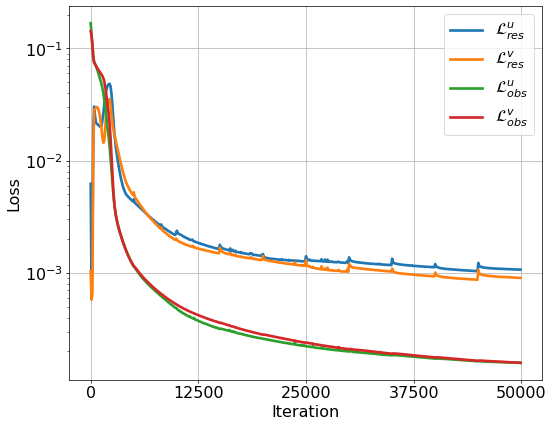

In [13]:
# loss曲线
log = np.load(os.path.join(log_path, 'log.npy'), allow_pickle=True).item()

fig = plt.figure(figsize=(9, 7), dpi=64)
ax = fig.subplots()

itv_plot = 100
ax.plot(log["iter"][1::itv_plot], log["loss_u_res"][1::itv_plot], label=r"$\mathcal{L}_{res}^{u}$", linewidth=3)
ax.plot(log["iter"][1::itv_plot], log["loss_v_res"][1::itv_plot], label=r"$\mathcal{L}_{res}^{v}$", linewidth=3)

ax.plot(log["iter"][1::itv_plot], log["loss_u_obs"][1::itv_plot], label=r"$\mathcal{L}_{obs}^{u}$", linewidth=3)
ax.plot(log["iter"][1::itv_plot], log["loss_v_obs"][1::itv_plot], label=r"$\mathcal{L}_{obs}^{v}$", linewidth=3)
# ax.plot(log["iter"][1::itv_plot], log["loss_p_obs"][1::itv_plot], label=r"$\mathcal{L}_{obs}^{p}$", linewidth=3)
ax.set_yscale('log')
ax.set_xticks(np.linspace(0, log["iter"][-1]+1, 5))
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
ax.legend(loc='upper right')
ax.grid()

plt.tight_layout()
plt.savefig(os.path.join(figure_path, 'loss.png'), dpi=64, bbox_inches='tight')
plt.show()

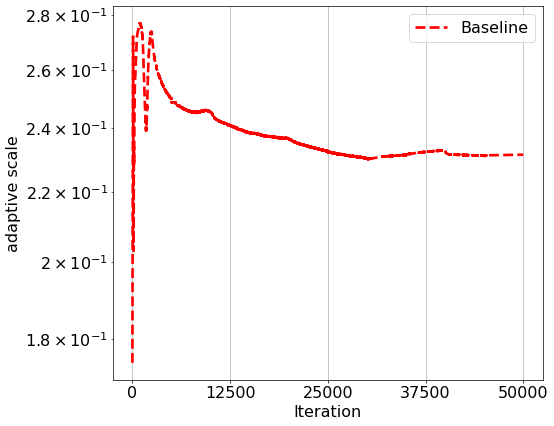

In [14]:
# ada_scale变化曲线
fig = plt.figure(figsize=(9, 7), dpi=64)
ax = fig.subplots()

itv_plot = 1
ax.plot(log["iter"][::itv_plot], log["ada_scale"][::itv_plot], label=r"Baseline", linewidth=3, color='red', linestyle="--")
# ax.plot(log["iter"][::itv_plot], (1e-2) * np.ones_like(log["iter"][::itv_plot]), label=r"$a_0 = " + f"{init_ada_scale:.2e}" + r"$", linewidth=3, color='black')
ax.set_yscale('log')
ax.set_xticks(np.linspace(0, log["iter"][-1]+1, 5))
ax.set_xlabel("Iteration")
ax.set_ylabel(r"adaptive scale")
ax.legend(loc='upper right')
ax.grid()

plt.tight_layout()
plt.savefig(os.path.join(figure_path, 'ada_sclae.png'), dpi=64, bbox_inches='tight')
plt.show()

In [15]:
# 定义数据集 -------
dataset = Dataset_NavierStokes2d(domain, device)
dataset.update_all_data()  # 加载/更新所有数据
dataset.statistic()  # 计算数据的统计信息，用作标准化
dataset.array2tensor()  # 将数据转到cuda

# 定义网络 -------
backbone = MLP(backbone_layers)
nn_param = MLP(nn_param_layers)
pinn = PINN_NavierStokes2d(backbone, nn_param, dataset.datad)
pinn = pinn.to(device)

In [16]:
# 载入PINN参数
model_state = torch.load(os.path.join(model_path, 'model_adam.pth'))
pinn.backbone.load_state_dict(model_state['backbone_state'])
pinn.nn_param.load_state_dict(model_state['nn_param_state'])
pinn.mean, pinn.std, pinn.var = model_state['mean'], model_state['std'], model_state['var']
pinn.ada_scale = model_state['ada_scale']
pinn.eval();

In [17]:
# 导入外部数据
data = io.loadmat(os.path.join(data_path, 'NS_Switch/udata3.mat'))
U = data["U"]
V = data["V"]
P = data["P"]

# 生成网格点形如[Ny, Nx, Nt] 适用
Nx = 65
Ny = 65
Nt = 129
x = np.linspace(xmin, xmax, Nx)
y = np.linspace(ymin, ymax, Ny)
t = np.linspace(tmin, tmax, Nt)

xx, yy = np.meshgrid(x, y)

xxx = np.repeat(xx[:, :, None], Nt, axis=2)
yyy = np.repeat(yy[:, :, None], Nt, axis=2)

tt = np.repeat(t[None, :], Nx, axis=0)
ttt = np.repeat(tt[None, :, :], Ny, axis=0)

In [18]:
# 计算误差
X = np.stack([xxx.flatten(), yyy.flatten(), ttt.flatten()], axis=1)
X = torch.from_numpy(X).float().to(device)

uvp_pred = pinn.net_u(X)

U_pred = uvp_pred[:, [0]]
U_pred = U_pred.detach().cpu().numpy().reshape(U.shape)
U_error = np.linalg.norm(U_pred - U) / np.linalg.norm(U)
print('Relative l2 error of U: {:.3e}'.format(U_error))

V_pred = uvp_pred[:, [1]]
V_pred = V_pred.detach().cpu().numpy().reshape(V.shape)
V_error = np.linalg.norm(V_pred - V) / np.linalg.norm(V)
print('Relative l2 error of V: {:.3e}'.format(V_error))

P_pred = uvp_pred[:, [2]]
P_pred = P_pred.detach().cpu().numpy().reshape(P.shape)
P_error = np.linalg.norm(P_pred - P) / np.linalg.norm(P)
print('Relative l2 error of P: {:.3e}'.format(P_error))

with open(os.path.join(log_path, 'relative_error.txt'), 'w') as f_obj:
    f_obj.write('Relative l2 error of U: {:.3e}\n'.format(U_error))
    f_obj.write('Relative l2 error of V: {:.3e}\n'.format(V_error))
    f_obj.write('Relative l2 error of P: {:.3e}\n'.format(P_error))

Relative l2 error of U: 3.451e-02
Relative l2 error of V: 3.511e-02
Relative l2 error of P: 9.400e-01


In [19]:
def exact_nu(t):
    nu = np.empty_like(t)
    for i in range(len(t)):
        if t[i] <= 0.5: nu[i] = 0.01
        else: nu[i] = siwtch_nu
    return nu

nu = exact_nu(t)

T = torch.from_numpy(t.reshape(-1, 1)).float().to(device)
nu_pred = pinn.net_param(T)
nu_pred = nu_pred.detach().cpu().numpy().reshape(t.shape)
nu_error = np.linalg.norm(nu_pred - nu) / np.linalg.norm(nu)
print('Relative l2 error of nu: {:.3e}'.format(nu_error))

with open(os.path.join(log_path, 'relative_error.txt'), 'w') as f_obj:
    f_obj.write('Relative l2 error of nu: {:.3e}\n'.format(nu_error))

Relative l2 error of nu: 9.299e-01


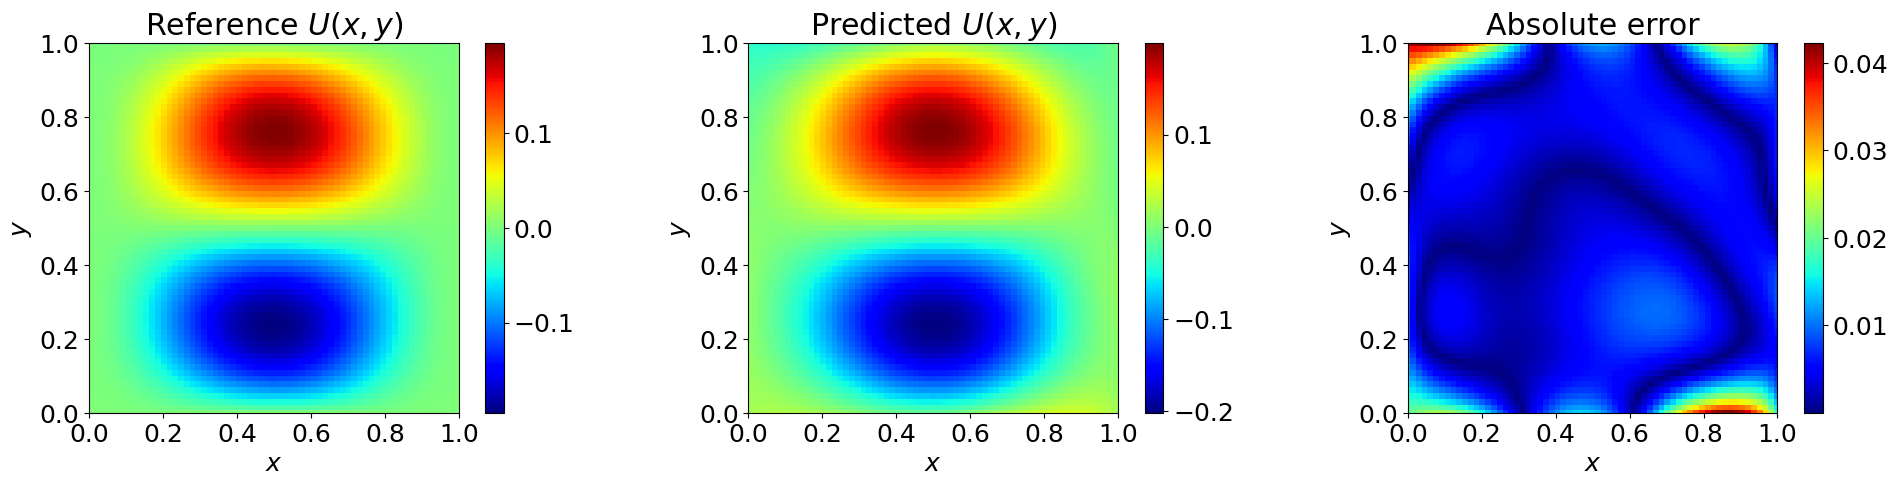

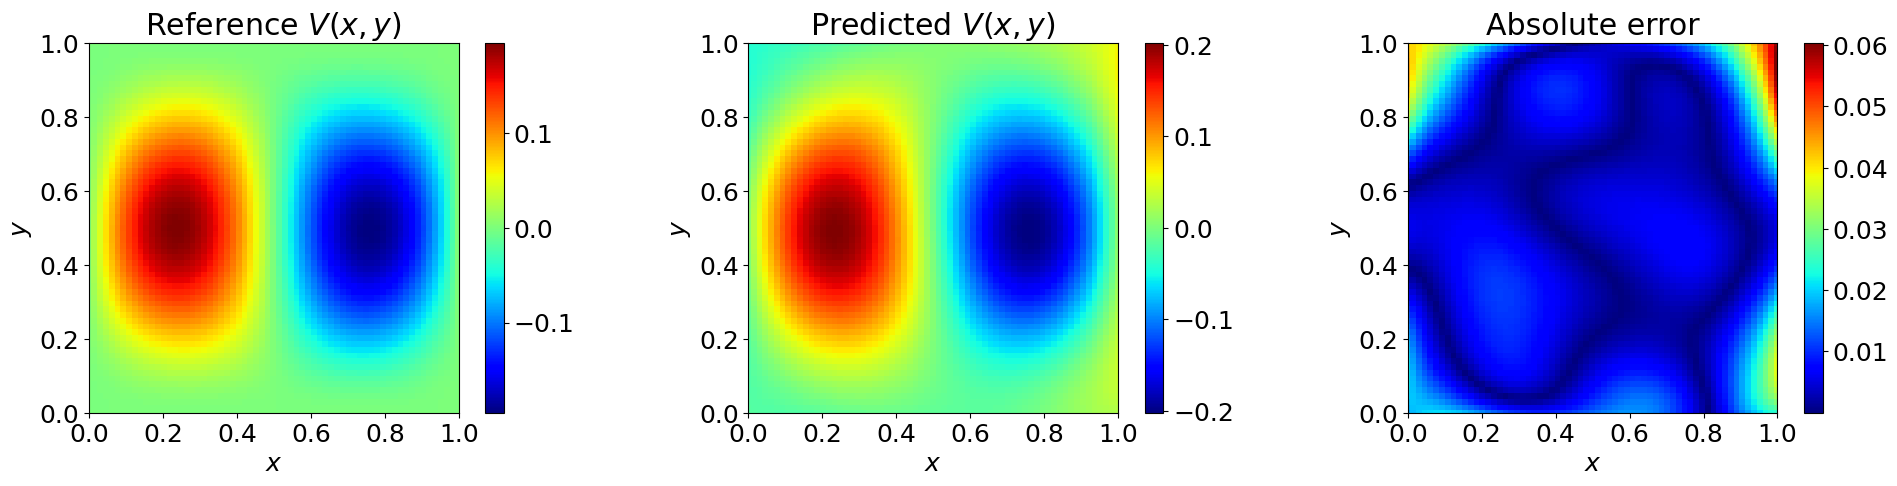

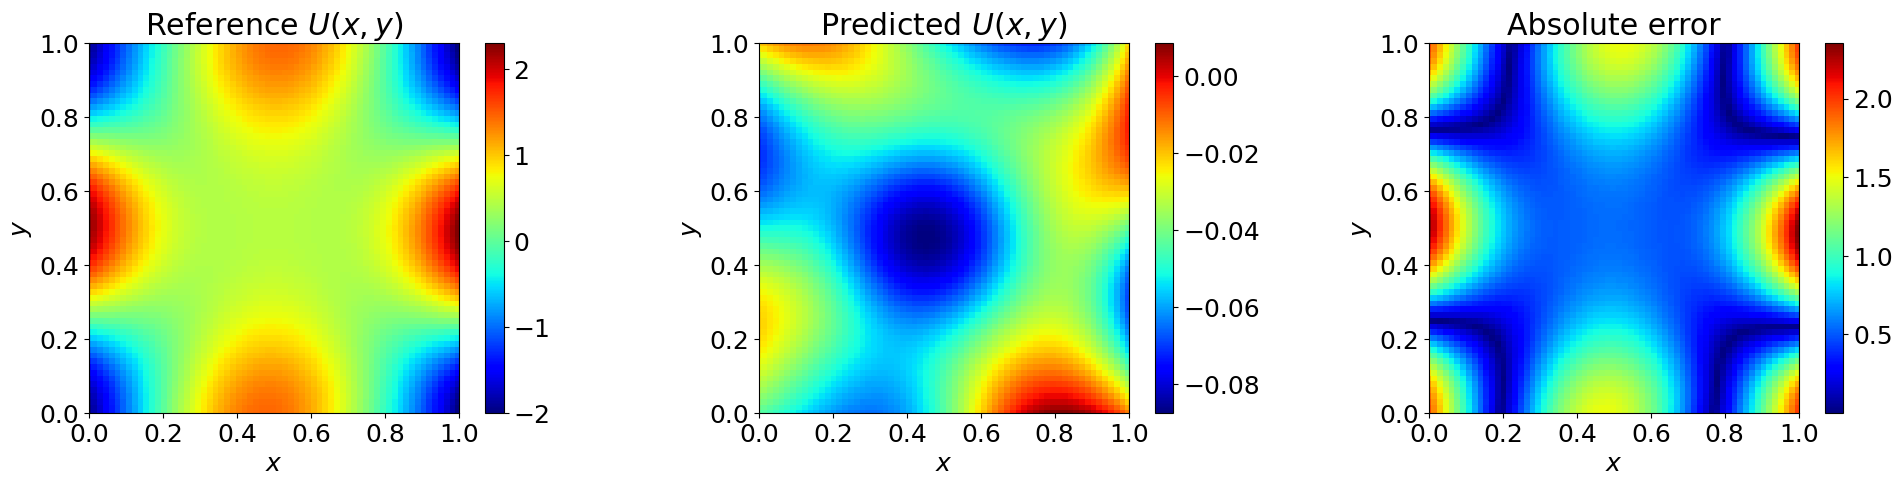

In [20]:
# 截面
snap = -1
uu = U[:, :, snap]
vv = V[:, :, snap]
pp = P[:, :, snap]

uu_pred = U_pred[:, :, snap]
vv_pred = V_pred[:, :, snap]
pp_pred = P_pred[:, :, snap]

xx = xxx[:, :, snap]
yy = yyy[:, :, snap]

# 画图 U -------
fig = plt.figure(figsize=(20, 5))
axes = fig.subplots(1, 3)

ax = axes[0]
cax = ax.pcolor(xx, yy, uu, cmap='jet')
cbar = fig.colorbar(cax)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title(r'Reference $U(x,y)$')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xticks(np.linspace(xmin, xmax, 6))
ax.set_yticks(np.linspace(ymin, ymax, 6))
ax.set_aspect(1./ax.get_data_ratio())

ax = axes[1]
cax = ax.pcolor(xx, yy, uu_pred, cmap='jet')
cbar = fig.colorbar(cax)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title(r'Predicted $U(x,y)$')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xticks(np.linspace(xmin, xmax, 6))
ax.set_yticks(np.linspace(ymin, ymax, 6))
ax.set_aspect(1./ax.get_data_ratio())

ax = axes[2]
cax = ax.pcolor(xx, yy, abs(uu_pred - uu), cmap='jet')
cbar = fig.colorbar(cax)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title(r'Absolute error')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xticks(np.linspace(xmin, xmax, 6))
ax.set_yticks(np.linspace(ymin, ymax, 6))
ax.set_aspect(1./ax.get_data_ratio())

plt.tight_layout()
plt.savefig(os.path.join(figure_path, 'u.png'), dpi=64, bbox_inches='tight')
plt.show()

# 画图 V -------
fig = plt.figure(figsize=(20, 5))
axes = fig.subplots(1, 3)

ax = axes[0]
cax = ax.pcolor(xx, yy, vv, cmap='jet')
cbar = fig.colorbar(cax)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title(r'Reference $V(x,y)$')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xticks(np.linspace(xmin, xmax, 6))
ax.set_yticks(np.linspace(ymin, ymax, 6))
ax.set_aspect(1./ax.get_data_ratio())

ax = axes[1]
cax = ax.pcolor(xx, yy, vv_pred, cmap='jet')
cbar = fig.colorbar(cax)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title(r'Predicted $V(x,y)$')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xticks(np.linspace(xmin, xmax, 6))
ax.set_yticks(np.linspace(ymin, ymax, 6))
ax.set_aspect(1./ax.get_data_ratio())

ax = axes[2]
cax = ax.pcolor(xx, yy, abs(vv_pred - vv), cmap='jet')
cbar = fig.colorbar(cax)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title(r'Absolute error')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xticks(np.linspace(xmin, xmax, 6))
ax.set_yticks(np.linspace(ymin, ymax, 6))
ax.set_aspect(1./ax.get_data_ratio())

plt.tight_layout()
plt.savefig(os.path.join(figure_path, 'v.png'), dpi=64, bbox_inches='tight')
plt.show()

# 画图 P -------
fig = plt.figure(figsize=(20, 5))
axes = fig.subplots(1, 3)

ax = axes[0]
cax = ax.pcolor(xx, yy, pp, cmap='jet')
cbar = fig.colorbar(cax)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title(r'Reference $U(x,y)$')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xticks(np.linspace(xmin, xmax, 6))
ax.set_yticks(np.linspace(ymin, ymax, 6))
ax.set_aspect(1./ax.get_data_ratio())

ax = axes[1]
cax = ax.pcolor(xx, yy, pp_pred, cmap='jet')
cbar = fig.colorbar(cax)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title(r'Predicted $U(x,y)$')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xticks(np.linspace(xmin, xmax, 6))
ax.set_yticks(np.linspace(ymin, ymax, 6))
ax.set_aspect(1./ax.get_data_ratio())

ax = axes[2]
cax = ax.pcolor(xx, yy, abs(pp_pred - pp), cmap='jet')
cbar = fig.colorbar(cax)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title(r'Absolute error')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xticks(np.linspace(xmin, xmax, 6))
ax.set_yticks(np.linspace(ymin, ymax, 6))
ax.set_aspect(1./ax.get_data_ratio())

plt.tight_layout()
plt.savefig(os.path.join(figure_path, 'p.png'), dpi=64, bbox_inches='tight')
plt.show()

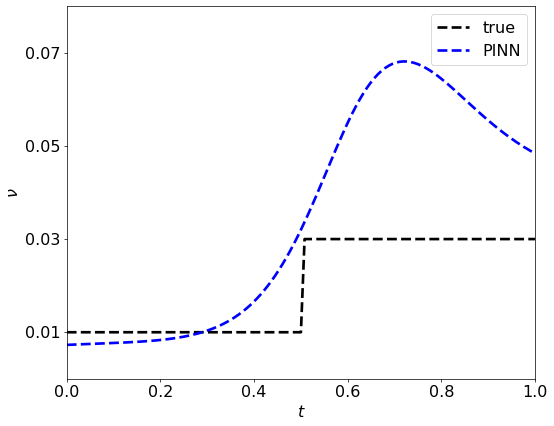

In [21]:
fig, ax = plt.subplots(figsize=(9, 7), dpi=64)
ax.plot(t, nu, linewidth=3, linestyle='--', color='black', label='true')
ax.plot(t, nu_pred, linewidth=3, linestyle='--', color='blue', label='PINN')
ax.set_xlim(tmin, tmax)
ax.set_ylim(0, 0.08)
ax.set_xticks(np.linspace(tmin, tmax, 6))
ax.set_yticks([0.01, 0.03, 0.05, 0.07])
ax.set_xlabel('$t$')
ax.set_ylabel(r'$\nu$')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig(os.path.join(figure_path, "nu.png"), dpi=64)
plt.show()

In [22]:
# io.savemat(os.path.join(data_path, 'NavierStokesDiscovery.mat'),{
#     'x':x, 
#     'y':y, 
#     't':t, 
#     'U':U, 
#     'V':V, 
#     'P':P, 
#     'U_pred':U_pred, 
#     'V_pred':V_pred, 
#     'P_pred':P_pred, 
# })